0.719953659653
-1


TypeError: unsupported operand type(s) for -: 'AxesSubplot' and 'AxesSubplot'

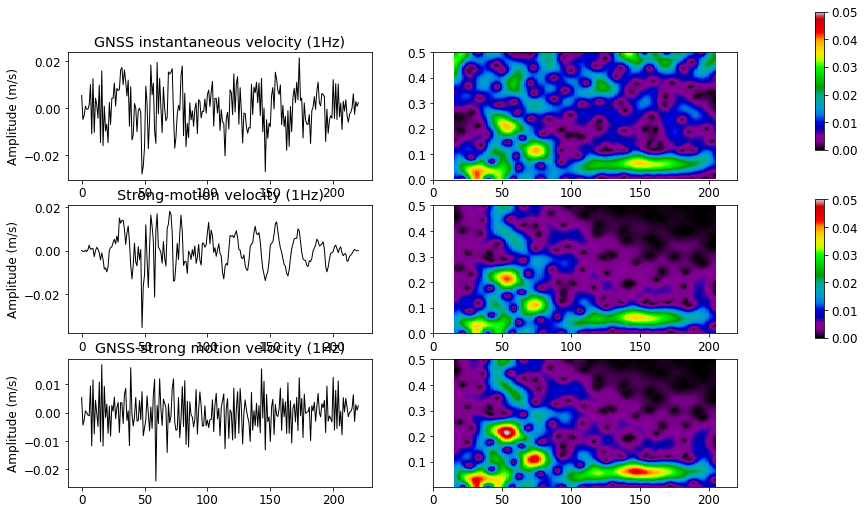

In [7]:
######## GNSS instavel Vs strong-motion derived velocity analysis and plots ##################
################################## Scipy version #############################################
####################################### Goals ################################################
#     1) Read a GNSS instavel and convert it into an obspy stream
#     2) Filter instavel
#     3) Load acceleration from IRIS client
#     4) Filter and integrate strong-motion acceleration to corresponding velocity
#     5) Subtract/find difference between GNSS and strong motion veocity
#     6) Subtract the difference from GNSS and plot trace
#     7) cross-correlate and plot both versions
##############################################################################################

from obspy import UTCDateTime 				
from obspy import Trace
from obspy import Stream
from obspy import read_inventory
from obspy.signal.cross_correlation import correlate
from obspy.clients.fdsn import Client 		
client=Client("IRIS")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.cm as cmx
import datetime

def compute_shift(cc):
    zero_index = int(len(cc) / 2) - 1
    shift = zero_index - np.argmax(cc)
    return shift

# READ INSTAVEL ASCII FILE
infile = 'Chignik_phase_vels/ac34_1hz.L2.igr.phase_vels'
site = np.genfromtxt(infile, dtype=None, encoding=None, names=['date','time','dt','lat','lon','height','vx', 'vy', 'vz', 'sigx', 'sigy', 'sigz', 'vdt', 'vn', 've', 'vu', 'sign', 'sige', 'sigu'])

# CREATE AN EMPTY STREAM AND POPULATE WITH INSTAVEL DATA
st_gnss_ve = Stream(Trace())
st_gnss_ve[0].stats.network = '--'
st_gnss_ve[0].stats.station = 'AC34'
st_gnss_ve[0].stats.channel = 'IVE'       # for [I]nst[V]el [E] component]
st_gnss_ve[0].stats.starttime = site["date"][0] + 'T' + site["time"][0]
st_gnss_ve[0].stats.sampling_rate = 1
st_gnss_ve[0].stats.calib = 1
st_gnss_ve[0].data = site['ve']
st_gnss_ve[0].detrend('linear')
st_gnss_ve[0].detrend('demean')
dt = UTCDateTime("2021-07-29T06:15:49.000000Z")
st_gnss_ve[0].trim(dt+80, dt+300)
#st_gnss_ve[0].plot()
#print(st_gnss_ve[0].max())

# TIDY UP GNSS VELOCITY TRACE -- FILTER THE HECK OUTTA THAT THING!!!!!!!!!!!
st_gnss_ve[0].filter('bandpass', freqmin=0.001, freqmax=0.499, corners=4, zerophase=True)
#st_gnss_ve[0].plot()
#print(st_gnss_ve[0].max())
#st_gnss_ve[0].filter('lowpass', freq=0.45, corners=2, zerophase=True)

# LOAD ONE SEISMIC ACCELERATION STREAM FROM IRIS DMC
start = UTCDateTime("2021-07-29T06:17:08.998400Z")
st_seis_ae = client.get_waveforms('AK', 'S19K', "*", 'HNE', (start), (start+220), attach_response=True)
#st_seis_ae[0].plot()
#print(st_seis_ae[0].max())

############ What's-in-there flags ################################
### The nearest strong-motion time-stamps are rounded to the ######
### corresponding GNSS ones. 'print' lines help with this #########
#print(st_seis_ae[0].data)
#print(len(st_seis_ae[0]))
#print(st_seis_ae[0].stats.starttime)
#print(st_seis_ae[0].times("utcdatetime"))
####################################################################

# TIDY UP ACCELERATION TRACE
st_seis_ae[0].remove_response(inventory=None, output="ACC", plot=False)
st_seis_ae[0].detrend('linear')
st_seis_ae[0].detrend('demean')
st_seis_ae[0].filter('bandpass', freqmin=0.001, freqmax=0.499, corners=4, zerophase=True)
#st_seis_ae[0].filter('lowpass', freq=5, corners=2, zerophase=True)
#st_seis_ae[0].plot()
#print(st_seis_ae[0].max())

# CREATE A SEISMIC VELOCITY TRACE
st_seis_ve = st_seis_ae[0].copy()
st_seis_ve.integrate(method='cumtrapz')
hz = st_seis_ve.data[::100]   # Brute-force 'downsampling' of strong-motion derived velocity to 1 Hz post-filtering and -integration
#st_seis_ve.plot()
#print(st_seis_ve.max())

# CREATE AN EMPTY STREAM AND POPULATE WITH 1Hz STRONG-MOTION DERIVED VELOCITY DATA
st_sm_ve = Stream(Trace())
st_sm_ve[0].stats.network = 'AK'
st_sm_ve[0].stats.station = 'S19K'
st_sm_ve[0].stats.channel = 'HNE'    
st_sm_ve[0].stats.starttime = UTCDateTime("2021-07-29T06:17:09.0Z")
st_sm_ve[0].stats.sampling_rate = 1
st_sm_ve[0].stats.calib = 1
st_sm_ve[0].data = hz

# DIFFERENCE
diff_ve = Stream(Trace())
diff_ve[0].stats.network = 'AK'
diff_ve[0].stats.station = 'AC34-S19K'
diff_ve[0].stats.channel = 'HNE'    
diff_ve[0].stats.starttime = UTCDateTime("2021-07-29T06:17:09.0Z")
diff_ve[0].stats.sampling_rate = 1
diff_ve[0].stats.calib = 1
diff_ve[0].data = ((st_gnss_ve[0].data)-hz)
#st_seis_ve.normalize()
#st_sm_ve[0].normalize()
#st_gnss_ve[0].normalize()

# CROSS CORRELATION
lags = np.arange(-220, 221)  
cc = correlate(st_gnss_ve[0].data, st_sm_ve[0].data, 220)
print(max(cc))
print(compute_shift(cc))

# CREATE STREAMS WITH ALL TRACES AND PLOT THEM
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size': 12})
#plt.style.use('seaborn')

fig, ax = plt.subplots(3,2)
ax[0,0].plot(st_gnss_ve[0].times(), st_gnss_ve[0].data, 'k-', linewidth=1, label=st_gnss_ve[0].stats['station'])
ax[0,0].set_title(f'GNSS instantaneous velocity (1Hz)')
ax[0,0].set_ylabel('Amplitude (m/s)')
ax[1,0].plot(st_sm_ve[0].times(), st_sm_ve[0].data, 'k-', linewidth=1, label=st_sm_ve[0].stats['station'])
ax[1,0].set_title(f'Strong-motion velocity (1Hz)')
ax[1,0].set_ylabel('Amplitude (m/s)')
ax[2,0].plot(diff_ve[0].times(), diff_ve[0].data, 'k-', linewidth=1, label=diff_ve[0].stats['station'])
ax[2,0].set_title(f'GNSS-strong motion velocity (1Hz)')
ax[2,0].set_ylabel('Amplitude (m/s)')

st_gnss_ve[0].spectrogram(axes=ax[0,1], show=True, samp_rate=st_gnss_ve[0].stats.sampling_rate, 
                          per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[0, 1].set_ylim((0,0.5))
ax[0, 1].images[0].set_clim(vmin=0, vmax=0.05)
mappable = ax[0,1].images[0]
ax33 = fig.add_axes([0.99, 0.71, 0.01, 0.24])
plt.colorbar(mappable=mappable, cax=ax33)

st_sm_ve[0].spectrogram(axes=ax[1,1], show=True, samp_rate=st_sm_ve[0].stats.sampling_rate, 
                        per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[1, 1].set_ylim((0,0.5))
ax[1, 1].images[0].set_clim(vmin=0, vmax=0.05)
mappable = ax[1,1].images[0]
ax23 = fig.add_axes([0.99, 0.384, 0.01, 0.24])
plt.colorbar(mappable=mappable, cax=ax23)

diff_ve[0].spectrogram(axes=ax[2,1], show=True, samp_rate=diff_ve[0].stats.sampling_rate, 
                       per_lap=0.99, wlen=30, log=False, cmap='nipy_spectral')
ax[2, 1].set_ylim((0,0.5))
ax[2, 1].images[0].set_clim(vmin=0, vmax=0.05)
mappable = ax[2,1].images[0]
ax13 = fig.add_axes([0.99, 0.058, 0.01, 0.24])
plt.colorbar(mappable=mappable, cax=ax13)
plt.tight_layout()

# TRACE LEGENDS
for row in ax[:,0]:
    ll = row.legend(loc=1)
    plt.setp(ll.get_texts(), color='red') #color legend

#ll = ax[2,1].legend(loc=1)
#plt.setp(ll.get_texts(), color='red') #color legend

plt.show()
